In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import keras.backend as K

In [4]:
kern = np.expand_dims(np.array([1, 2, 1]), axis=-1)
print(kern.shape)
r = np.outer(kern, kern)
print(r.shape)
print(r)

(3, 1)
(3, 3)
[[1 2 1]
 [2 4 2]
 [1 2 1]]


In [5]:
tester = np.random.normal(0, 1, (4, 4, 16))
std = np.std(tester)
alt_std = np.sqrt(np.mean(tester**2))
print(std, alt_std)

0.9019142105766313 0.9038999453243821


(457, 626, 3)
457
0.94
429
28
(256, 256, 3)


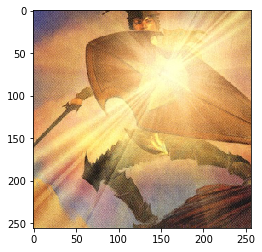

In [6]:
def img_resize(img, y_dim, x_dim):
    if img.shape[0]*img.shape[1] < y_dim*x_dim:
        img = cv2.resize(img,
                         (y_dim, x_dim),
                         interpolation=cv2.INTER_CUBIC)
    else:
        img = cv2.resize(img,
                         (y_dim, x_dim),
                         interpolation=cv2.INTER_AREA)
    return img

def crop_square_from_rec(img, img_dim=256):
    img = cv2.imread(img)
    img = np.rot90(img)
    # resize based on smallest axis
    smallest_axis = img.shape[:2].index(min(img.shape[:2]))
    scale = img_dim/img.shape[smallest_axis]
    img = img_resize(img,
                     int(img.shape[0]*scale),
                     int(img.shape[1]*scale))

    # crop square from image
    smallest_axis = img.shape[:2].index(min(img.shape[:2]))
    largest_axis = [axis for axis in [0, 1] if axis != smallest_axis][0]
    largest_axis_len = img.shape[largest_axis]
    possible_crops = largest_axis_len-img_dim
    rand_position = np.random.randint(possible_crops)
    if smallest_axis == 0:
        img = img[:, rand_position:rand_position+img_dim, ::-1]
    else:
        img = img[rand_position:rand_position+img_dim, :, ::-1]
    return img

def card_crop(img_path, img_dim=256):
    img = cv2.imread(img_path)
    img = img[:, :, ::-1]
    print(img.shape)
    smallest_axis_len = min(img.shape[:2])
    print(smallest_axis_len)
    percent = np.random.randint(80, 101)/100
    print(percent)
    target_crop_size = int(smallest_axis_len*percent)
    print(target_crop_size)
    x_positions = img.shape[0]-target_crop_size
    y_positions = img.shape[1]-target_crop_size
    print(x_positions)
    rand_x = np.random.randint(x_positions)
    rand_y = np.random.randint(y_positions)
    img = img[rand_x:rand_x+target_crop_size,
              rand_y:rand_y+target_crop_size,
              :]
    img = img_resize(img, img_dim, img_dim)
    # randomly flip horizontally
    flip_val = np.random.randint(2)
    if flip_val == 0:
        img = img[:, ::-1, :]

    return img

path = "data/mtg_images/0b0c98ba-3505-40aa-b0f2-e03c9790f51e_1517813031_['W'].jpg"
img = card_crop(path)
print(img.shape)
plt.imshow(img)
plt.show()

In [65]:
import keras.backend as K
numpy_kernel = [[1, 1, 1, 1, 1],
                [1, 4, 4, 4, 1],
                [1, 4, 6, 4, 1],
                [1, 4, 4, 4, 1],
                [1, 1, 1, 1, 1]]

numpy_kernel = [[1, 1, 1, 1, 1, 1, 1],
                [1, 6, 6, 6, 6, 6, 1],
                [1, 6, 15, 15, 15, 6, 1],
                [1, 6, 15, 20, 15, 6, 1],
                [1, 6, 15, 15, 15, 6, 1],
                [1, 6, 6, 6, 6, 6, 1],
                [1, 1, 1, 1, 1, 1, 1]]

numpy_kernel = numpy_kernel/np.sum(numpy_kernel)
kernel = K.constant(numpy_kernel)
#kernel = K.constant([[0.1, 0.1, 0.1],
#                     [0.1, 0.2, 0.1],
#                     [0.1, 0.1, 0.1]])
kernel = K.expand_dims(kernel, axis=-1)
kernel = K.expand_dims(kernel, axis=-1)
kernel = K.tile(kernel, (1, 1, 1, 3))
print(K.int_shape(kernel))

(7, 7, 1, 3)


In [66]:
img_tensor = K.constant(img)
img_tensor = K.expand_dims(img_tensor, axis=0)

(1, 256, 256, 3)


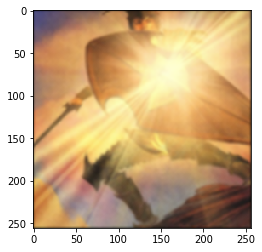

In [67]:
result_tensor = K.conv2d(img_tensor, kernel, strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1))
result_tensor = K.eval(result_tensor)
print(result_tensor.shape)
result_tensor = np.squeeze(result_tensor)
result_tensor = result_tensor.astype(np.uint8)
plt.imshow(result_tensor)
plt.show()

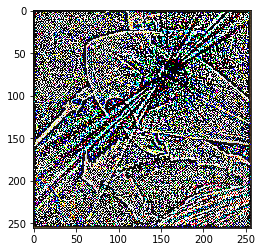

In [68]:
#result_tensor = np.expand_dims(result_tensor, axis=-1)
#result_tensor = np.tile(result_tensor, (1, 1, 3))
high_pass_img = img - result_tensor
plt.imshow(high_pass_img)
plt.show()

In [10]:

result_tensor = np.squeeze(result_tensor)
result_tensor = result_tensor.astype(np.uint8)
result_tensor = result_tensor[::2, ::2, :].copy()
print(result_tensor.shape)
result_tensor = Image.fromarray(result_tensor)
result_tensor.save("low_pass_and_subsampled_kernel4.png")
#plt.imshow(result_tensor)
#plt.show()#

IndexError: too many indices for array

In [119]:
keras_avg = K.pool2d(img_tensor, (2, 2), strides=(2, 2), padding='same', data_format='channels_last', pool_mode='avg')
keras_avg = K.eval(keras_avg)
keras_avg = np.squeeze(keras_avg)
keras_avg = keras_avg.astype(np.uint8)
print(keras_avg.shape)
keras_avg = Image.fromarray(keras_avg)
keras_avg.save("avg_pool_stride2_pool2.png")

#plt.imshow(keras_avg)
#plt.show()

(128, 128, 3)


In [121]:
keras_bilinear = K.resize_images(img_tensor, 2, 2, 'channels_last', 'bilinear')
keras_bilinear = K.eval(keras_bilinear)
keras_bilinear = np.squeeze(keras_bilinear)
keras_bilinear = keras_bilinear.astype(np.uint8)
print(keras_bilinear.shape)
keras_bilinear = Image.fromarray(keras_bilinear)
keras_bilinear.save("keras_bilinear_upsample.png")

(512, 512, 3)


In [123]:
constructive = K.repeat_elements(img_tensor, 2, 1)
constructive = K.repeat_elements(constructive, 2, 2)
constructive = K.depthwise_conv2d(constructive, kernel, strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1))
constructive = K.eval(constructive)
constructive = np.squeeze(constructive)
constructive = constructive.astype(np.uint8)
print(constructive.shape)
constructive = Image.fromarray(constructive)
constructive.save("upsample_lowpass.png")

(512, 512, 3)


In [16]:
def crop_square_from_rec(img, img_dim=256):
    img = np.rot90(img)
    # resize based on smallest axis
    smallest_axis = img.shape[:2].index(min(img.shape[:2]))
    scale = img_dim/img.shape[smallest_axis]
    img = img_resize(img,
                     int(img.shape[0]*scale),
                     int(img.shape[1]*scale))

    # crop square from image
    smallest_axis = img.shape[:2].index(min(img.shape[:2]))
    largest_axis = [axis for axis in [0, 1] if axis != smallest_axis][0]
    largest_axis_len = img.shape[largest_axis]
    possible_crops = largest_axis_len-img_dim
    rand_position = np.random.randint(possible_crops)
    if smallest_axis == 0:
        img = img[:, rand_position:rand_position+img_dim, ::-1]
    else:
        img = img[rand_position:rand_position+img_dim, :, ::-1]
    img = img_resize(img, img_dim, img_dim)
    return img

tray = np.random.normal(0, 1, (253, 512, 3))
tim = crop_square_from_rec(tray, 256)
print(tim.shape)

(255, 256, 3)


In [1]:
from keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet')
print(model.summary())

C:\Users\Wolfgang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
102858752/102853048 [==============================] - 9s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv